<a href="https://www.kaggle.com/toygarr/yemeksepeti-sentiment-analysis?scriptVersionId=82433941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# *I hope this notebook will give you an intuition about data handling by purpose and creating different type of training models* 

* I did not explain the code line by line, however, I tried to keep it as simple as possible. Have a nice ml day.

In [136]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# nltk
import nltk
from nltk.corpus import stopwords

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [137]:
nltk.download('stopwords')
!pip install TurkishStemmer
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Settings

In [201]:
TEST_SIZE = 0.1

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^a-zA-Z0-9ğüşöçıİĞÜŞÖÇ]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 16
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 512

# SENTIMENT
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
SENTIMENT_THRESHOLD = (0.65)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (1-5 = negative, 6-10 = positive) -> custom feature, we created target feature to be able to make binary classification
* **speed**: speed point
* **service**: service point
* **flavour**: flavour point
* **review**: the text of the comments (Superdi.)

In [139]:
df= pd.read_csv("../input/yorumsepeti/yorumsepeti.csv", sep=';')

In [140]:
print("Dataset size:", len(df))

Dataset size: 60242


In [141]:
df.head(5)

,speed,service,flavour,review
0,-,1,1,Her zaman komşu fırından sipariş verdiğim için...
1,-,10,2,sosisli ürün isteyen adama peynirli bişey yol...
2,-,10,10,Siparisimi cok hizli getiren ekip arkadasiniza...
3,1,1,7,"After waiting more tjan one hour, they didnt d..."
4,4,4,1,Iyi pişsin diye söylememe rağmen az pişmiş gel...


In [142]:
df['Character Count'] = df['review'].apply(lambda x: len(str(x)))
df['Character Count'].max(axis = 0, skipna = True)

310

In [143]:
pd.isna(df['review']).sum()

33

### Pre-Process dataset

In [144]:
df = df.dropna(subset=['review'], axis=0)

In [145]:
# We will use the mean of 3 point scoring system
# so we will change the dataset to target-text

df['speed'] = df['speed'].replace(['-'], np.nan)
df['service'] = df['service'].replace(['-'], np.nan)
df['flavour'] = df['flavour'].replace(['-'], np.nan)

df['speed'] = df['speed'].astype(float)
df['service'] = df['service'].astype(float)
df['flavour'] = df['flavour'].astype(float)
df['review'] = df['review'].astype(str)

df = df.assign(target=df.loc[:, ['speed', 'service', 'flavour']].mean(axis=1))
df['target'] = round(df['target'])

df = df.dropna(subset=['target'], axis=0)
df['target'] = df['target'].astype(int)

In [146]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,1
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,6
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,10
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,3
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,3
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,10
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,10
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,10
60240,10.0,10.0,10.0,Harikasınız!,12,10


### Converting the target to binary depending on mean of 3 types of point

In [147]:
decode_map = { 1:"NEGATIVE", 2:"NEGATIVE" ,3: "NEGATIVE", 4:"NEGATIVE", 5:"NEGATIVE",6: "POSITIVE",
              7: "POSITIVE", 8: "POSITIVE", 9: "POSITIVE", 10: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [148]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 33.5 ms, sys: 844 µs, total: 34.4 ms
Wall time: 35 ms


In [149]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,Her zaman komşu fırından sipariş verdiğim için...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yol...,135,POSITIVE
2,NaN,10.0,10.0,Siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,"After waiting more tjan one hour, they didnt d...",85,NEGATIVE
4,4.0,4.0,1.0,Iyi pişsin diye söylememe rağmen az pişmiş gel...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,Super.,6,POSITIVE
60238,10.0,10.0,10.0,Mükemmelsiniz.,14,POSITIVE
60239,10.0,10.0,10.0,Çorbası efsane mutlaka deneyin.,31,POSITIVE
60240,10.0,10.0,10.0,Harikasınız!,12,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

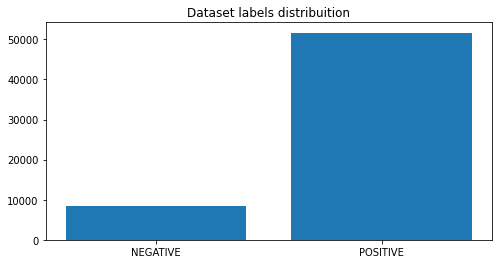

In [196]:
target_cnt = Counter(df.target)

plt.figure(figsize=(8,4))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [151]:
stop_words = stopwords.words("turkish")

In [152]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [153]:
%%time
df.review = df.review.apply(lambda x: preprocess(x))

CPU times: user 1.39 s, sys: 16.3 ms, total: 1.4 s
Wall time: 1.4 s


In [154]:
df

,speed,service,flavour,review,Character Count,target
0,NaN,1.0,1.0,zaman komşu fırından sipariş verdiğim eksik gö...,202,NEGATIVE
1,NaN,10.0,2.0,sosisli ürün isteyen adama peynirli bişey yoll...,135,POSITIVE
2,NaN,10.0,10.0,siparisimi cok hizli getiren ekip arkadasiniza...,63,POSITIVE
3,1.0,1.0,7.0,after waiting more tjan one hour they didnt de...,85,NEGATIVE
4,4.0,4.0,1.0,iyi pişsin söylememe rağmen pişmiş geldi birda...,73,NEGATIVE
...,...,...,...,...,...,...
60237,10.0,10.0,10.0,super,6,POSITIVE
60238,10.0,10.0,10.0,mükemmelsiniz,14,POSITIVE
60239,10.0,10.0,10.0,çorbası efsane mutlaka deneyin,31,POSITIVE
60240,10.0,10.0,10.0,harikasınız,12,POSITIVE


### Split train and test

In [155]:
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 54185
TEST size: 6021


### Word2Vec 

In [156]:
%%time
documents = [_text.split() for _text in df_train.review] 

CPU times: user 107 ms, sys: 31.5 ms, total: 139 ms
Wall time: 138 ms


In [157]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [158]:
w2v_model.build_vocab(documents)

In [159]:
vocab_len = len(w2v_model.wv)
print("Vocab size", vocab_len)

Vocab size 4775


In [160]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 30.9 s, sys: 154 ms, total: 31.1 s
Wall time: 16.7 s


(5897324, 8096368)

In [161]:
w2v_model.wv.most_similar("tatlı")

[('puding', 0.7210612297058105),
 ('hediye', 0.715035080909729),
 ('kurabiye', 0.677828848361969),
 ('tatlılar', 0.6576290726661682),
 ('ikramı', 0.6477929353713989),
 ('ikram', 0.6285188794136047),
 ('düşünce', 0.6252636313438416),
 ('tatlısı', 0.6206542253494263),
 ('tatlıyı', 0.6199080348014832),
 ('gönderdiğiniz', 0.6171516180038452)]

### Tokenize Text

In [162]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 46043
CPU times: user 1.46 s, sys: 68.6 ms, total: 1.53 s
Wall time: 1.43 s


In [163]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.14 s, sys: 67.4 ms, total: 2.21 s
Wall time: 2.21 s


In [164]:
labels = df_train.target.unique().tolist()
labels

['POSITIVE', 'NEGATIVE']

In [165]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (54185, 300)
y_train (54185, 1)

x_test (6021, 300)
y_test (6021, 1)


____________________________________

### Imbalanced distribution handling

In [166]:
from imblearn.over_sampling import SMOTE

def smote(x, y):
    smote = SMOTE(sampling_strategy= 1, random_state=42)
    x, y = smote.fit_resample(x, y)
    return x, y

In [167]:
print(x_train.shape)
print(y_train.shape)

(54185, 300)
(54185, 1)


In [168]:
# CREATING DICTIONARY TO SEE CLASS DIST
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{1: 46502, 0: 7683}

In [169]:
x_train, y_train = smote(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(93004, 300)
(93004,)


In [170]:
## CONTROL THE AUGMENTED DISTRIBUTION
df_c = pd.DataFrame(y_train)
value_counts = df_c.value_counts()
dictionary = dict()
for (i,), j in value_counts.items():
    dictionary[i] = j

dictionary

{0: 46502, 1: 46502}

### Embedding layer

In [171]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(46043, 300)


### Build Model

In [172]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], 
                                            input_length=SEQUENCE_LENGTH, trainable=False)

sequence_input = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = tf.keras.layers.SpatialDropout1D(0.2)(embedding_sequences)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 300)          13812900  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 300, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

### Compile model

In [173]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [174]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [175]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=3,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/3
164/164 [==============================] - 623s 4s/step - loss: 0.3534 - accuracy: 0.8361 - val_loss: 0.2390 - val_accuracy: 0.9024
Epoch 2/3
164/164 [==============================] - 609s 4s/step - loss: 0.2491 - accuracy: 0.8907 - val_loss: 0.2002 - val_accuracy: 0.9158
Epoch 3/3
164/164 [==============================] - 613s 4s/step - loss: 0.2237 - accuracy: 0.9020 - val_loss: 0.1449 - val_accuracy: 0.9412
CPU times: user 47min 5s, sys: 6min 44s, total: 53min 49s
Wall time: 31min 27s


### Evaluate

In [176]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 3s 182ms/step - loss: 0.2616 - accuracy: 0.8812

ACCURACY: 0.881248950958252
LOSS: 0.26164501905441284
CPU times: user 2.78 s, sys: 12.3 ms, total: 2.79 s
Wall time: 3.11 s


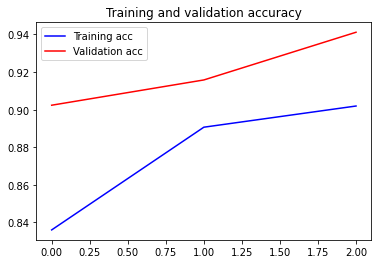

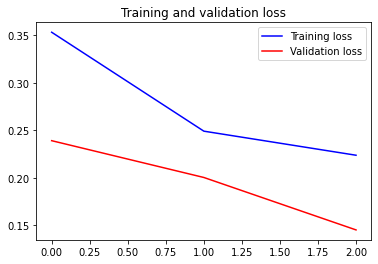

In [177]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Predict

In [178]:
def decode_sentiment(score):
    if score <= SENTIMENT_THRESHOLD:
        label = NEGATIVE
    else:
        label = POSITIVE

    return label

In [179]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [180]:
predict("Lütfen şu yemeği düzgün pişirin")

{'label': 'NEGATIVE',
 'score': 0.4808890223503113,
 'elapsed_time': 0.7288949489593506}

In [181]:
predict("İşini aşkla yapan bir mekan daha sarrrrdı")

{'label': 'POSITIVE',
 'score': 0.9688620567321777,
 'elapsed_time': 0.2424941062927246}

In [182]:
predict("Kuryeniz çok saygısız")

{'label': 'NEGATIVE',
 'score': 0.48918214440345764,
 'elapsed_time': 0.31424403190612793}

In [183]:
predict("lezzet sıfır kalite sıfır hizmet sıfır ekmek arası ekmek de göndermezsiniz.")

{'label': 'NEGATIVE',
 'score': 0.22740545868873596,
 'elapsed_time': 0.4173719882965088}

In [184]:
predict("EFFFFSANEYDİ BEEE")

{'label': 'POSITIVE',
 'score': 0.8553884625434875,
 'elapsed_time': 0.32649970054626465}

In [185]:
predict("Ellerinize sağlık çok güzeldi")

{'label': 'POSITIVE',
 'score': 0.9994321465492249,
 'elapsed_time': 0.2803940773010254}

In [186]:
predict("Bi tantuni yiyelim dedik kusacaktık reziller sizi")

{'label': 'NEGATIVE',
 'score': 0.4676267206668854,
 'elapsed_time': 0.28522515296936035}

In [187]:
predict("Hep buradan alıyoruz yine memnunuz teşekkürler")

{'label': 'POSITIVE',
 'score': 0.9920886754989624,
 'elapsed_time': 0.28423476219177246}

In [188]:
predict("bir daha burdan almayın paranıza yazık")

{'label': 'NEGATIVE',
 'score': 0.1256287842988968,
 'elapsed_time': 0.2808713912963867}

### Confusion Matrix

In [189]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 1s 820ms/step
CPU times: user 869 ms, sys: 33.5 ms, total: 903 ms
Wall time: 1.2 s


In [199]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

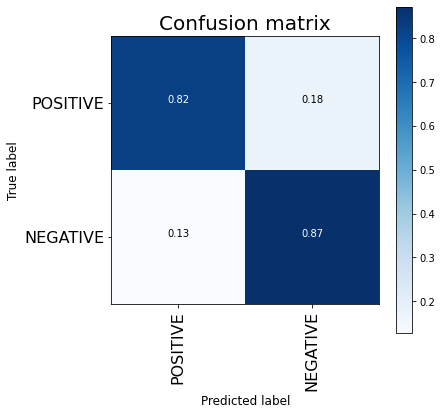

CPU times: user 320 ms, sys: 83.6 ms, total: 403 ms
Wall time: 280 ms


In [200]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [192]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.52      0.82      0.64       867
    POSITIVE       0.97      0.87      0.92      5154

    accuracy                           0.87      6021
   macro avg       0.74      0.85      0.78      6021
weighted avg       0.90      0.87      0.88      6021



### Accuracy Score

In [193]:
accuracy_score(y_test_1d, y_pred_1d)

0.8651386812821791

### Save model

In [194]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)